In [62]:
%pip install -q datasets transformers

In [63]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/radicals")

  0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
ds['train'].features

{'radical_image': Image(decode=True, id=None),
 'meta': {'id': Value(dtype='int32', id=None),
  'characters': Value(dtype='string', id=None),
  'slug': Value(dtype='string', id=None)}}

In [65]:
radical_ids = set()
for meta in ds['train']['meta']:
    radical_ids.add(meta['id'])

unique_radical_ids = sorted(list(radical_ids))
num_classes = len(unique_radical_ids)
radical_id_to_index = {radical_id: idx for idx, radical_id in enumerate(unique_radical_ids)}

In [69]:
import numpy as np

def set_label(example):
    return {"label": radical_id_to_index[example['meta']['id']]}

In [70]:
ds_one_hot = ds.map(set_label)

Map:   0%|          | 0/17560 [00:00<?, ? examples/s]

In [74]:
ds_train = ds_one_hot.remove_columns(["meta"])

In [75]:
resized_ds = ds_train.map(lambda example: {"radical_image": example['radical_image'].resize((64, 64))})

Map:   0%|          | 0/17560 [00:00<?, ? examples/s]

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.fc3 = nn.Linear(num_classes, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net(num_classes)

In [78]:
resized_ds.set_format(type='torch', columns=['radical_image', 'label'])

In [79]:
normalized_ds = resized_ds.map(lambda example: {"radical_image": example['radical_image'].unsqueeze(0) / 255.0})

Map:   0%|          | 0/17560 [00:00<?, ? examples/s]

In [80]:
splits = normalized_ds['train'].train_test_split(test_size=0.1, shuffle=True)

In [91]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(splits['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(splits['test'], batch_size=batch_size)

In [92]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [93]:
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=439, bias=True)
)

In [95]:
losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for idx, batch in enumerate(train_loader):
        images, labels = batch['radical_image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)
        losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if idx % 40 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['radical_image'].to(device), batch['label'].to(device)
            outputs = model(images)
            loss = F.nll_loss(outputs, labels)
            test_loss += loss.item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
        print(f"Epoch {epoch+1}/{num_epochs}, Accuracy:{correct / len(test_loader.dataset) * 100}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {test_loss/len(test_loader)}")
    scheduler.step()

Epoch 1/10, Step 1/494, Loss: 5.884321212768555
Epoch 1/10, Step 41/494, Loss: 5.943821907043457
Epoch 1/10, Step 81/494, Loss: 5.847715377807617
Epoch 1/10, Step 121/494, Loss: 5.67427396774292
Epoch 1/10, Step 161/494, Loss: 5.726499080657959
Epoch 1/10, Step 201/494, Loss: 5.6235198974609375
Epoch 1/10, Step 241/494, Loss: 5.670410633087158
Epoch 1/10, Step 281/494, Loss: 5.586800575256348
Epoch 1/10, Step 321/494, Loss: 5.7059431076049805
Epoch 1/10, Step 361/494, Loss: 5.419567584991455
Epoch 1/10, Step 401/494, Loss: 5.682821750640869
Epoch 1/10, Step 441/494, Loss: 5.402562141418457
Epoch 1/10, Step 481/494, Loss: 5.359045505523682
Epoch 1/10, Accuracy:1.5945330296127564, Train Loss: 5.635339659717884, Val Loss: 167.47291287508878
Epoch 2/10, Step 1/494, Loss: 5.123435974121094
Epoch 2/10, Step 41/494, Loss: 4.921565532684326
Epoch 2/10, Step 81/494, Loss: 5.194090843200684
Epoch 2/10, Step 121/494, Loss: 5.27958869934082
Epoch 2/10, Step 161/494, Loss: 4.763051509857178
Epoch 2

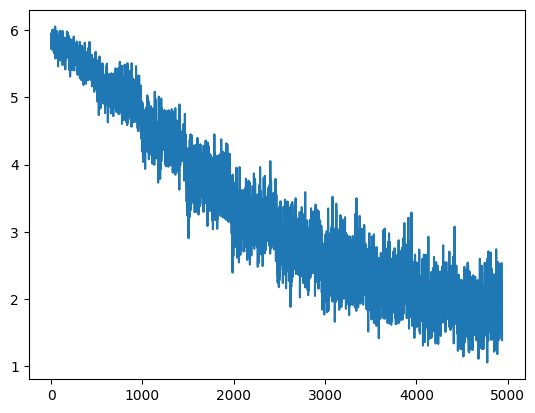

In [96]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [99]:
model.eval()
correct = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['radical_image'].to(device), batch['label'].to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
    print(f"Accuracy: {correct}/{len(test_loader.dataset)} -  {correct / len(test_loader.dataset) * 100}")

Accuracy: 767/1756 -  43.678815489749425


Label: 357, Prediction: 357


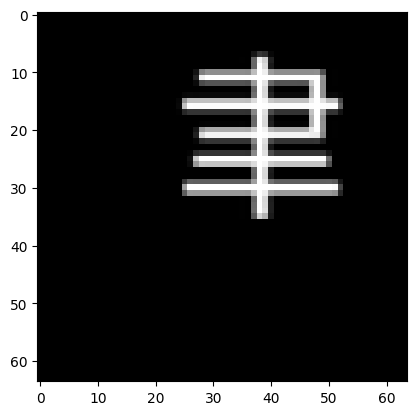

Label: 328, Prediction: 311


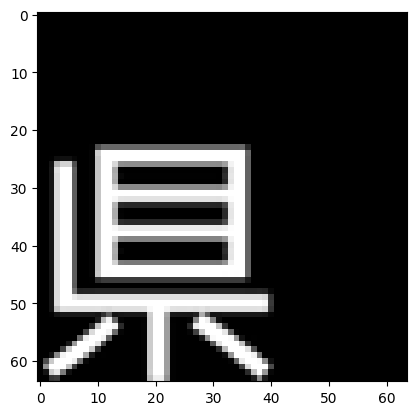

Label: 136, Prediction: 307


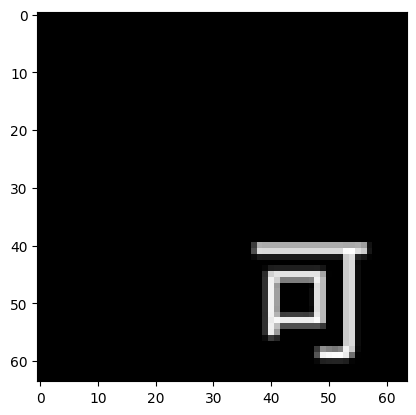

Label: 298, Prediction: 298


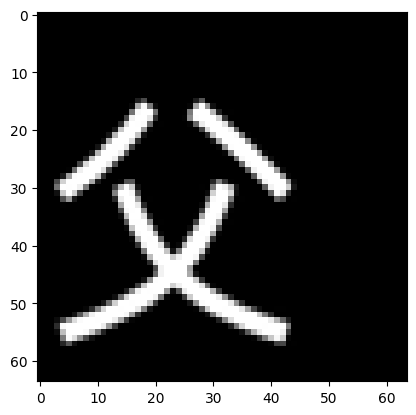

Label: 45, Prediction: 120


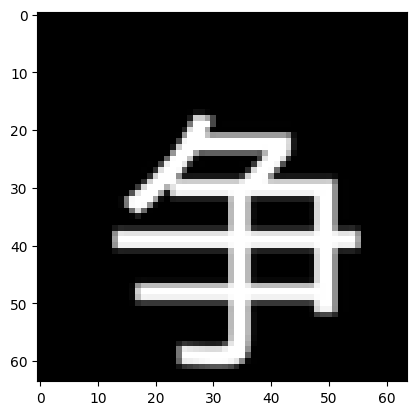

Label: 428, Prediction: 359


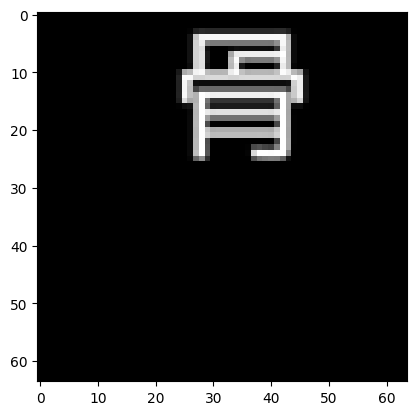

Label: 154, Prediction: 154


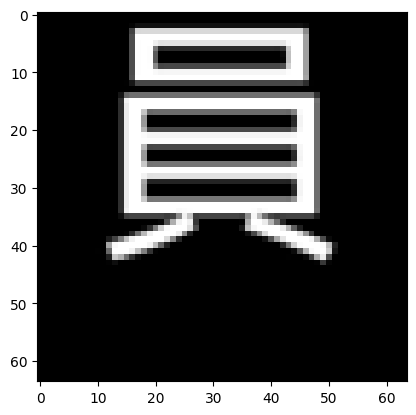

Label: 204, Prediction: 13


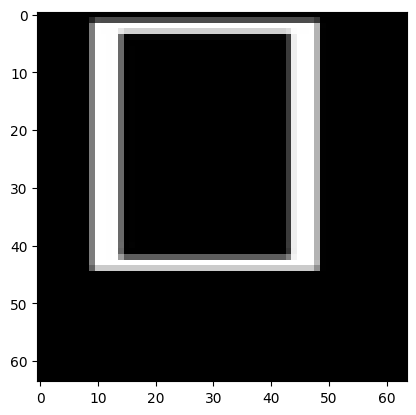

Label: 383, Prediction: 383


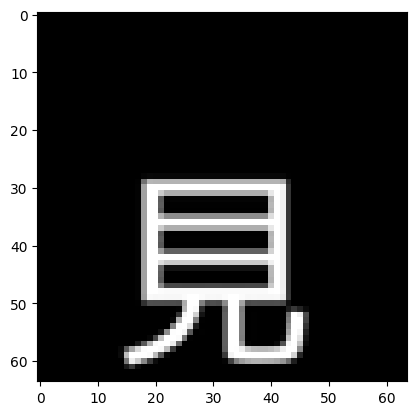

Label: 261, Prediction: 383


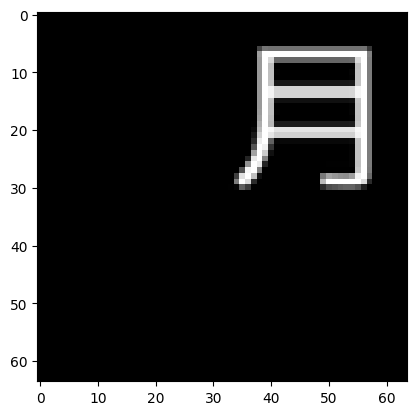

In [104]:
import random

for i in range(10):
    random_idx = random.randint(0, len(test_loader.dataset))

    example = test_loader.dataset[random_idx]
    image = example['radical_image'].unsqueeze(0).to(device)
    output = model(image)
    pred = output.argmax(dim=1, keepdim=True)
    print(f"Label: {example['label']}, Prediction: {pred.item()}")
    plt.imshow(example['radical_image'].squeeze(0).cpu(), cmap='gray')
    plt.show()